# SEO Crawl Dataset Exploration

## A template for first steps in analyzing a crawl dataset

This dataset was generated using the unreleased version 0.11.0 of advertools. It is a crawl of the URLs of Django's website https://djangoproject.com. 
The following function call starts crawling from the home page, follows links (`follow_links=True`), discovers and crawls all pages, and saves the output to the specified path `output_file=django1.jl`.  
The parameter `allowed_domains` restricts the crawler to those mentioned (sub)domains. In this case I wanted to check `docs` and `www`. There is a huge code.djangoproject.com domain for issues and tickets (~0.5M pages), which was not included.  
The crawler produces logs for every page crawled, and all the details can be saved to a file for later checking (errors, URLs blocked by robots.txt, etc). You simply have to specify a file path for that under `custom_settings`.

For large websites it's good to create a `JOBDIR` which allows you to pause and resume whenever you want, without having to worry about re-crawling and handling duplicates.


`import advertools as adv`  

`adv.crawl('https://djangoproject.com',  
           output_file='django1.jl',     
           follow_links=True,  
           allowed_domains=['docs.djangoproject.com', 'www.djangoproject.com'],  
           custom_settings={'LOG_FILE': 'django.log'  
                            'JOBDIR': 'dj_job_1'})`

In this video, we go through and discuss this notebook, so you might be interested in following along:

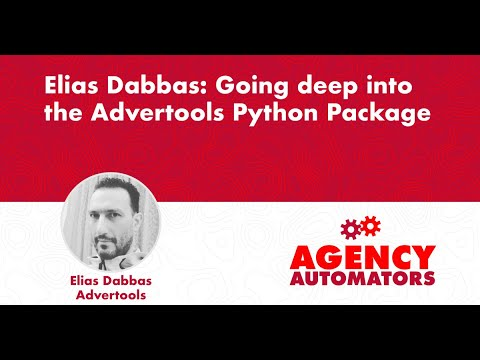

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo(id='CR4mDpFJoXs', width=800, height=500)

In [2]:
%%capture
!pip install advertools

In [3]:
import advertools as adv
import pandas as pd
pd.options.display.max_columns = None
import ipywidgets as widgets
from IPython.display import display
from dataset_utilities import value_counts_plus

for p in [adv, pd, widgets]:
    print(f'{p.__name__:–<15}v{p.__version__}')


advertools–––––v0.10.7
pandas–––––––––v1.1.3
ipywidgets–––––v7.5.1


# Dataset Structure

* Each URL is independently and completely represented by a row
* Each column contains information about one, and only one attribute of a URL
* Multiple elements on a page, if available, are separated by two @ signs and live in one cell, for example `one@@two@@three`
* Missing vs. empty elements: Having a missing value `NaN` means that that element does not exist on the page. On the other hand, an empty value, means that the element exists, but its text attribute is the empty string "". For example `<h2></h2>` is an h2 tag that exits on a page, yet empty (contains no text).

Examples are always easier: 

url | title | h1 | h2 | h2 split
----|-------|----|----|---------
https://example.com | Home Page | Welcome to the site | Sign up@@Subscribe to the newsletter | ["Sign up", "Subscribe to the newsletter"]
https://example.com/about | About Us | Learn more about us | Our Story@@How we Started@@What we do | ["Our Story", "How we Started", "What we do"]
https://example.com/product_1 | Product One | `NaN` | Specs@@Price@@Details | ["Specs", "Price", "Details"]
https://example.com/product_2 | Product Two | Welcome to the site | | [""]


<br>

All pages contain one h1 tag, with the exception of `/product_1` , which does _not_ have an h1 tag.

All pages contain multiple h2 tags, (2, 3, 3, and 1) separated by the two @ signs, with the exception of `/product_2`, it has one h2 tag, but it's empty. The column `h2 split` shows the actual values after splitting them.

## Data Format
By default the crawl dataset is saved as a `jsonlines` file with the extension `.jl`. This format saves each row independently, and allows for flexibility in representing data, because not all pages contain the same data, and so they can be different (contain different columns). Once you import them as a DataFrame, columns are aligned automatically. 

I already saved to a CSV format by using the `pd.DataFrame.to_csv` method. 


In [4]:
crawl_df = pd.read_csv('/kaggle/input/seocrawldatasets/django.csv',
                       parse_dates=['crawl_time', 'resp_headers_last-modified', 'resp_headers_date', 'resp_headers_expires'],
                       low_memory=False)
print(f'Shape: {crawl_df.shape}')
crawl_df.head(3)

Shape: (35463, 59)


,url,title,viewport,charset,h1,h2,h3,h4,body_text,size,download_timeout,download_slot,download_latency,redirect_times,redirect_ttl,redirect_urls,redirect_reasons,depth,status,links_url,links_text,links_nofollow,img_src,img_alt,ip_address,crawl_time,resp_headers_server,resp_headers_content-type,resp_headers_content-language,resp_headers_x-frame-options,resp_headers_x-content-type-options,resp_headers_x-xss-protection,resp_headers_expires,resp_headers_cache-control,resp_headers_strict-transport-security,resp_headers_access-control-allow-origin,resp_headers_accept-ranges,resp_headers_date,resp_headers_via,resp_headers_age,resp_headers_x-served-by,resp_headers_x-cache,resp_headers_x-cache-hits,resp_headers_x-timer,resp_headers_vary,request_headers_accept,request_headers_accept-language,request_headers_user-agent,request_headers_accept-encoding,canonical,alt_href,alt_hreflang,request_headers_referer,resp_headers_set-cookie,resp_headers_last-modified,request_headers_cookie,resp_headers_etag,h5,resp_headers_x-robots-tag
0,https://www.djangoproject.com/,The Web framework for perfectionists with dead...,"width=device-width, initial-scale=1",utf-8,Django@@Meet Django@@Stay in the loop@@Django ...,Support Django!@@Learn More@@Get Involved@@Fol...,Latest news@@New to Django?@@The power of Djan...,\n @@\n @@\n @@\n,The web framework for perfectionists with dead...,17026,180,djangoproject.com,0.599493,1.0,19.0,https://djangoproject.com,301,0,200,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...,https://static.djangoproject.com/img/fundraisi...,Support Django!,199.232.18.217,2020-11-15 12:24:33,nginx,text/html; charset=utf-8,en,SAMEORIGIN,nosniff,1; mode=block,2020-11-15 12:27:47+00:00,max-age=300,max-age=31536000; includeSubDomains; preload,https://code.djangoproject.com,bytes,2020-11-15 12:24:33+00:00,1.1 varnish,0.0,cache-vie21629-VIE,MISS,0,"S1605443073.134884,VS0,VE564","Accept-Language, Accept-Encoding","text/html,application/xhtml+xml,application/xm...",en,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"gzip, deflate",NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,https://docs.djangoproject.com/en/3.1/intro/in...,Quick install guide | Django documentation | D...,"width=device-width, initial-scale=1",utf-8,Quick install guide@@Additional Information@@D...,Install Python@@Set up a database@@Install Dja...,NaN,NaN,The web framework for perfectionists with dead...,23821,180,docs.djangoproject.com,0.035209,1.0,19.0,https://docs.djangoproject.com/en/stable/intro...,302,1,200,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...,https://static.djangoproject.com/img/fundraisi...,Support Django!,199.232.18.217,2020-11-15 12:24:34,nginx,text/html; charset=utf-8,NaN,SAMEORIGIN,nosniff,1; mode=block,2020-11-14 12:16:16+00:00,max-age=300,max-age=31536000; includeSubDomains; preload,https://code.djangoproject.com,bytes,2020-11-15 12:24:34+00:00,1.1 varnish,87198.0,cache-vie21632-VIE,HIT,1,"S1605443074.250706,VS0,VE1",Accept-Encoding,"text/html,application/xhtml+xml,application/xm...",en,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"gzip, deflate",https://docs.djangoproject.com/en/3.1/intro/in...,https://docs.djangoproject.com/el/3.1/intro/in...,el@@en@@es@@fr@@id@@ja@@ko@@pl@@pt-br@@zh-hans,https://www.djangoproject.com/,NaN,NaT,NaN,NaN,NaN,NaN
2,https://www.djangoproject.com/weblog/2020/nov/...,"Django bugfix releases issued: 3.1.3, 3.0.11, ...","width=device-width, initial-scale=1",utf-8,Additional Information@@Django Links,"Django bugfix releases issued: 3.1.3, 3.0.11, ...",NaN,NaN,The web framework for perfectionists with dead...,34251,180,www.djangoproject.com,0.639925,NaN,NaN,NaN,NaN,1,200,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...,https://st

# URLs Blocked by robots.txt:
The crawl logs file contains lines that indicate the URLs that were blocked, and therefore, no request/response was made to them.  

The following code creates a regex pattern to find and extract those URLs, and adds them to the list `blocked_urls`.  
This is a example of such a line:  

`2020-11-15 13:24:36 [scrapy.downloadermiddlewares.robotstxt] DEBUG: Forbidden by robots.txt: <GET https://docs.djangoproject.com/zh-hans/3.0/internals/mailing-lists/>`

In [5]:
import re
regex = '20\d\d-\d\d-\d\d \d\d:\d\d:\d\d.*?Forbidden by robots\.txt: <GET (.*?)>'
blocked_urls = []

with open('/kaggle/input/seocrawldatasets/django.log') as file: 
    for line in file: 
        url = re.findall(regex, line) 
        if url: 
            blocked_urls.append(url[0]) 


print(f'Number of blocked URLs: {len(blocked_urls):,}\n\nSample:')
blocked_urls[:10]

Number of blocked URLs: 26,515

Sample:


['https://docs.djangoproject.com/zh-hans/3.0/internals/mailing-lists/',
 'https://docs.djangoproject.com/pl/3.0/internals/mailing-lists/',
 'https://docs.djangoproject.com/ko/3.0/internals/mailing-lists/',
 'https://docs.djangoproject.com/ja/3.0/internals/mailing-lists/',
 'https://docs.djangoproject.com/zh-hans/3.1/internals/mailing-lists/',
 'https://docs.djangoproject.com/pt-br/3.1/internals/mailing-lists/',
 'https://docs.djangoproject.com/pl/3.1/internals/mailing-lists/',
 'https://docs.djangoproject.com/ko/3.1/internals/mailing-lists/',
 'https://docs.djangoproject.com/ja/3.1/internals/mailing-lists/',
 'https://docs.djangoproject.com/fr/3.1/internals/mailing-lists/']

# XML Sitemaps

The function `sitemap_to_df` crawls (multiple) sitemaps, and converts them to a DataFrame. It can take a regular sitemap, or a sitemap index. 


`import advertools as adv`  
`django_sitemap = adv.sitemap_to_df('https://www.djangoproject.com/sitemap.xml')`


In [6]:
sitemaps_df = pd.read_csv('/kaggle/input/seocrawldatasets/django_sitemaps.csv')
sitemaps_df.head()

,loc,changefreq,priority,sitemap,sitemap_size_mb,download_date
0,https://docs.djangoproject.com/es/3.1/contents/,daily,0.1,https://docs.djangoproject.com/sitemap-es.xml,0.132162,2020-11-20 17:23:11.336140+00:00
1,https://docs.djangoproject.com/es/3.1/glossary/,daily,0.1,https://docs.djangoproject.com/sitemap-es.xml,0.132162,2020-11-20 17:23:11.336140+00:00
2,https://docs.djangoproject.com/es/3.1/index/,daily,0.1,https://docs.djangoproject.com/sitemap-es.xml,0.132162,2020-11-20 17:23:11.336140+00:00
3,https://docs.djangoproject.com/es/3.1/_modules/,daily,0.1,https://docs.djangoproject.com/sitemap-es.xml,0.132162,2020-11-20 17:23:11.336140+00:00
4,https://docs.djangoproject.com/es/3.1/_modules...,daily,0.1,https://docs.djangoproject.com/sitemap-es.xml,0.132162,2020-11-20 17:23:11.336140+00:00


In [7]:
sitemaps_df['sitemap'].value_counts().to_frame().style.background_gradient(cmap='cividis').format('{:,}')

,sitemap
https://docs.djangoproject.com/sitemap-en.xml,"5,771"
https://docs.djangoproject.com/sitemap-fr.xml,"2,427"
https://docs.djangoproject.com/sitemap-id.xml,"1,933"
https://docs.djangoproject.com/sitemap-pt-br.xml,"1,257"
https://docs.djangoproject.com/sitemap-el.xml,"1,107"
https://docs.djangoproject.com/sitemap-pl.xml,986
https://docs.djangoproject.com/sitemap-ja.xml,952
https://docs.djangoproject.com/sitemap-es.xml,948
https://docs.djangoproject.com/sitemap-ko.xml,781
https://docs.djangoproject.com/sitemap-zh-hans.xml,708


## Compare sitemaps and crawled URLs

In [8]:
mycolors = {'blue', 'green', 'red', 'yellow'}

yourcolors = {'blue', 'green', 'orange', 'purple'}

In [9]:
mycolors.intersection(yourcolors)

{'blue', 'green'}

In [10]:
mycolors.union(yourcolors)

{'blue', 'green', 'orange', 'purple', 'red', 'yellow'}

In [11]:
in_sitemap_not_crawled = set(sitemaps_df['loc']).difference(crawl_df['url'])
crawled_not_in_sitemap = set(crawl_df['url']).difference(sitemaps_df['loc'])

print(f'In sitemap not crawled: {len(in_sitemap_not_crawled):>7,}')
print(f'Crawled not in sitemap: {len(crawled_not_in_sitemap):>7,}')

In sitemap not crawled:   2,051
Crawled not in sitemap:  19,973


# `crawl_df` Exploration

In [12]:
print('crawl_df Shape:', crawl_df.shape)
crawl_df.head(2)

crawl_df Shape: (35463, 59)


,url,title,viewport,charset,h1,h2,h3,h4,body_text,size,download_timeout,download_slot,download_latency,redirect_times,redirect_ttl,redirect_urls,redirect_reasons,depth,status,links_url,links_text,links_nofollow,img_src,img_alt,ip_address,crawl_time,resp_headers_server,resp_headers_content-type,resp_headers_content-language,resp_headers_x-frame-options,resp_headers_x-content-type-options,resp_headers_x-xss-protection,resp_headers_expires,resp_headers_cache-control,resp_headers_strict-transport-security,resp_headers_access-control-allow-origin,resp_headers_accept-ranges,resp_headers_date,resp_headers_via,resp_headers_age,resp_headers_x-served-by,resp_headers_x-cache,resp_headers_x-cache-hits,resp_headers_x-timer,resp_headers_vary,request_headers_accept,request_headers_accept-language,request_headers_user-agent,request_headers_accept-encoding,canonical,alt_href,alt_hreflang,request_headers_referer,resp_headers_set-cookie,resp_headers_last-modified,request_headers_cookie,resp_headers_etag,h5,resp_headers_x-robots-tag
0,https://www.djangoproject.com/,The Web framework for perfectionists with dead...,"width=device-width, initial-scale=1",utf-8,Django@@Meet Django@@Stay in the loop@@Django ...,Support Django!@@Learn More@@Get Involved@@Fol...,Latest news@@New to Django?@@The power of Djan...,\n @@\n @@\n @@\n,The web framework for perfectionists with dead...,17026,180,djangoproject.com,0.599493,1.0,19.0,https://djangoproject.com,301,0,200,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...,https://static.djangoproject.com/img/fundraisi...,Support Django!,199.232.18.217,2020-11-15 12:24:33,nginx,text/html; charset=utf-8,en,SAMEORIGIN,nosniff,1; mode=block,2020-11-15 12:27:47+00:00,max-age=300,max-age=31536000; includeSubDomains; preload,https://code.djangoproject.com,bytes,2020-11-15 12:24:33+00:00,1.1 varnish,0.0,cache-vie21629-VIE,MISS,0,"S1605443073.134884,VS0,VE564","Accept-Language, Accept-Encoding","text/html,application/xhtml+xml,application/xm...",en,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"gzip, deflate",NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,https://docs.djangoproject.com/en/3.1/intro/in...,Quick install guide | Django documentation | D...,"width=device-width, initial-scale=1",utf-8,Quick install guide@@Additional Information@@D...,Install Python@@Set up a database@@Install Dja...,NaN,NaN,The web framework for perfectionists with dead...,23821,180,docs.djangoproject.com,0.035209,1.0,19.0,https://docs.djangoproject.com/en/stable/intro...,302,1,200,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...,https://static.djangoproject.com/img/fundraisi...,Support Django!,199.232.18.217,2020-11-15 12:24:34,nginx,text/html; charset=utf-8,NaN,SAMEORIGIN,nosniff,1; mode=block,2020-11-14 12:16:16+00:00,max-age=300,max-age=31536000; includeSubDomains; preload,https://code.djangoproject.com,bytes,2020-11-15 12:24:34+00:00,1.1 varnish,87198.0,cache-vie21632-VIE,HIT,1,"S1605443074.250706,VS0,VE1",Accept-Encoding,"text/html,application/xhtml+xml,application/xm...",en,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"gzip, deflate",https://docs.djangoproject.com/en/3.1/intro/in...,https://docs.djangoproject.com/el/3.1/intro/in...,el@@en@@es@@fr@@id@@ja@@ko@@pl@@pt-br@@zh-hans,https://www.djangoproject.com/,NaN,NaT,NaN,NaN,NaN,NaN


In [13]:
crawl_df['status'].value_counts()

200    32045
404     3418
Name: status, dtype: int64

## How long did the crawl take? 

Each row has a timestamp showing when it was crawled under `crawl_time`. Assuming the crawl happened in one job, we can simply subtract the minimum time from the maximum time, and the difference would be the answer.

In [14]:
duration = crawl_df['crawl_time'].max() - crawl_df['crawl_time'].min()
print(f'Crawl duration: {duration}')
print(f'Pages crawled per second: {len(crawl_df) / duration.seconds:.3f}')


Crawl duration: 0 days 05:18:06
Pages crawled per second: 1.858


# Counting occurrences of non-numeric values on pages
For each page element, the following questions can be interesting to explore: 

- How many occurrences of a certain element does this site have (especially for elements that occur multiple times on a page: h2, h3, links_url, links_text, etc.)?
- How many pages do _not_ contain this element?
- How many times is this element duplicated?
- How many unique values form 70%, 80%, etc. of the total?

The below dropdown shows all available non-numeric columns in the `crawl_df` and allows you to answer the above questions interactively.

## Column names:

* `count`: The simple count of this value of this element across pages.
* `cum_count`: The cumulative counts of elements up to this points.
* `perc`: The percentage of the total for this element.
* `cum_perc`: The cumulative percentage of of this element up to this point. This is where you can set priorities, knowing that the first seven elements (out of 500) form 75% of your values for example.
* `Others:` This row contains all other values grouped in one row. You can use the slider to change how many rows you want to see, and this would change the count of `Others`. By default, it is displayed at the end of the table, but you can select `sort_others` to place this row in its sorted location in the table.


## Counts Meaning and Interpretation

The counts would have different meanings in different situations, and based on which element you are looking at, for example:

* It's not a problem if you have a page with a missing `h5` tag, but a page with a missing `title` tag probably is.
* Having multiple `h3` tags on the same page is perfectly normal, but multiple canonicals defeats the purpose.
* Three duplicated links on all pages linking to the home page, about us, and contact pages is perfectly normal, but having your `title` tag duplicatd across all pages is generally considered a problem.
* In many cases you have to be the judge.

Here's an example of how to use this interactively:

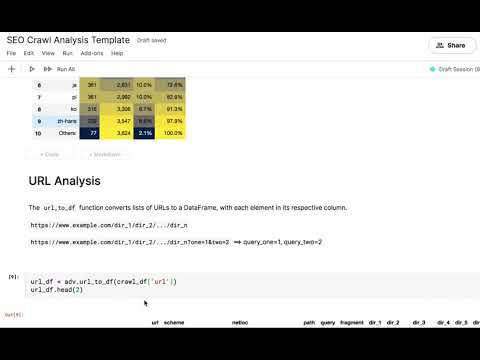

In [15]:
from IPython.display import YouTubeVideo
YouTubeVideo('IZUBvDfDbqo', width=896, height=480)

### **You need to run the notebook for this to work, you can do so by forking it `Copy and Edit`, and hitting `Run All`**

In [16]:
def count_column_values(col_name, show_top=10, sort_others=False):
    series = crawl_df[col_name].str.split('@@').explode()
    print(f'Number of {series.name}s: {series.count():,}')
    print(f'Number of pages: {len(crawl_df):,}')
    print(f'{series.name}s per page: {series.count()/len(crawl_df):.2f}')
    display(value_counts_plus(series, sort_others=sort_others, dropna=False, show_top=show_top))

widgets.interact(count_column_values,
                 col_name=crawl_df.select_dtypes('object').columns,
                 show_top=widgets.IntSlider(min=1, max=50, value=10));

Number of urls: 35,463
Number of pages: 35,463
urls per page: 1.00


,url,count,cum_count,perc,cum_perc
0,https://www.djangoproject.com/community/q-and-a/?page=9859,1,1,0.0%,0.0%
1,https://www.djangoproject.com/community/q-and-a/?page=371,1,2,0.0%,0.0%
2,https://www.djangoproject.com/community/q-and-a/?page=1625,1,3,0.0%,0.0%
3,https://www.djangoproject.com/community/links/?page=633,1,4,0.0%,0.0%
4,https://docs.djangoproject.com/en/3.0/_modules/django/utils/module_loading/,1,5,0.0%,0.0%
5,https://docs.djangoproject.com/id/dev/releases/1.3.5/,1,6,0.0%,0.0%
6,https://www.djangoproject.com/community/q-and-a/?page=9852,1,7,0.0%,0.0%
7,https://www.djangoproject.com/community/q-and-a/?page=4755,1,8,0.0%,0.0%
8,https://docs.djangoproject.com/en/dev/topics/db/,1,9,0.0%,0.0%
9,https://www.djangoproject.com/community/q-and-a/?page=1222,1,10,0.0%,0.0%


# URL Analysis
The `url_to_df` function converts lists of URLs to a DataFrame, with each element in its respective column.

`https://www.example.com/dir_1/dir_2/.../dir_n`

`https://www.example.com/dir_1/dir_2/.../dir_n?one=1&two=2` ==> query_one=1, query_two=2

In [17]:
example_urls = [
    'https://www.example.com/one/two/three?price=10&color=red',
    
    'http://example.com/one/two?color=blue&price=15&size=small'
]

adv.url_to_df(example_urls)

,url,scheme,netloc,path,query,fragment,dir_1,dir_2,dir_3,query_price,query_color,query_size
0,https://www.example.com/one/two/three?price=10...,https,www.example.com,/one/two/three,price=10&color=red,,one,two,three,10,red,NaN
1,http://example.com/one/two?color=blue&price=15...,http,example.com,/one/two,color=blue&price=15&size=small,,one,two,NaN,15,blue,small


In [18]:
url_df = adv.url_to_df(crawl_df['url'])
url_df.head()

,url,scheme,netloc,path,query,fragment,dir_1,dir_2,dir_3,dir_4,dir_5,dir_6,dir_7,dir_8,dir_9,dir_10,dir_11,dir_12,query_next,query_page,query_from,query_utm_content,query_utm_medium,query_utm_source,query_utm_campaign
0,https://www.djangoproject.com/,https,www.djangoproject.com,/,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://docs.djangoproject.com/en/3.1/intro/in...,https,docs.djangoproject.com,/en/3.1/intro/install/,,,en,3.1,intro,install,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.djangoproject.com/weblog/2020/nov/...,https,www.djangoproject.com,/weblog/2020/nov/02/bugfix-releases/,,,weblog,2020,nov,02,bugfix-releases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.djangoproject.com/foundation/,https,www.djangoproject.com,/foundation/,,,foundation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://docs.djangoproject.com/en/dev/internal...,https,docs.djangoproject.com,/en/dev/internals/security/,,reporting-security-issues,en,dev,internals,security,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Some questions that you might be interested in:

* Do they have sub-domains? How many URLs each?
* How deep is their directory structure? /dir_1/dir_2.../dir__?
* What are the different values, and the counts, of elements in `dir_1`, `dir_2`, etc.?
* Under the /products/ `dir_1` directory, what is the split of categories `dir_2` for example?
* In the English URLs `/en/` (`dir_1`), where `/category/` (`dir_3`) is "bags", what is the split of "brands" (`dir_4`) for example?
* Do they use query parameters? If so, how many of each?
* Filter the URLs that have `query_price` and sort them in descending order by the same column.
* Which color does the website have most of (`query_color`), and how many products have a color?

The above are some examples and you can definitely think of others as well.

## How "full/empty" are those URL elements?

In [19]:
(url_df
 .replace('', pd.NA)
 .notna()
 .mean().round(2)
 .to_frame()
 .rename_axis('URL Element')
 .rename(columns={'index': 'URL element', 
                  0: 'URLs using it (%)'})
 .assign(count=url_df.replace('', pd.NA).notna().sum())
 .style
 .format({'URLs using it (%)': '{:.1%}',
          'count': '{:,}'}))

,URLs using it (%),count
URL Element,,
url,100.0%,"35,463"
scheme,100.0%,"35,463"
netloc,100.0%,"35,463"
path,100.0%,"35,463"
query,38.0%,"13,335"
fragment,4.0%,"1,524"
dir_1,100.0%,"35,461"
dir_2,100.0%,"35,384"
dir_3,61.0%,"21,745"


In [20]:
def count_column_values(col_name, show_top=10, sort_others=False):
    series = url_df[col_name].str.split('@@').explode()
    print(f'Number of {series.name}s: {series.count():,}')
    print(f'Number of pages: {len(crawl_df):,}')
    print(f'{series.name}s per page: {series.count()/len(crawl_df):.2f}')
    display(value_counts_plus(series, sort_others=sort_others, dropna=False, show_top=show_top))

widgets.interact(count_column_values,
                 col_name=url_df.select_dtypes('object').columns,
                 show_top=widgets.IntSlider(min=1, max=50, value=10));

Number of urls: 35,463
Number of pages: 35,463
urls per page: 1.00


,url,count,cum_count,perc,cum_perc
0,https://www.djangoproject.com/community/q-and-a/?page=9859,1,1,0.0%,0.0%
1,https://www.djangoproject.com/community/q-and-a/?page=9852,1,2,0.0%,0.0%
2,https://www.djangoproject.com/weblog/2013/sep/20/djangocon-us-2013-wrapup/,1,3,0.0%,0.0%
3,https://www.djangoproject.com/weblog/2005/dec/11/weekinreview/,1,4,0.0%,0.0%
4,https://www.djangoproject.com/community/q-and-a/?page=1625,1,5,0.0%,0.0%
5,https://www.djangoproject.com/community/links/?page=633,1,6,0.0%,0.0%
6,https://docs.djangoproject.com/en/3.0/_modules/django/utils/module_loading/,1,7,0.0%,0.0%
7,https://docs.djangoproject.com/id/dev/releases/1.3.5/,1,8,0.0%,0.0%
8,https://www.djangoproject.com/community/q-and-a/?page=4755,1,9,0.0%,0.0%
9,https://www.djangoproject.com/community/q-and-a/?page=7569,1,10,0.0%,0.0%


# Canonicals

How many canonical tags do we have per page?

In [21]:
(crawl_df
 ['canonical']
 .str.split('@@')
 .str.len()
 .value_counts(dropna=False)
)

NaN    18113
1.0    17350
Name: canonical, dtype: int64

There are 18,113 pages containing no canonical tags, and the remaining 17,350 contain one each.  
We can extract and split the URLs and canonicals based on whether or not, they point to themselves. We can do this by checking if `url` is (not) equal to `canonical`:

In [22]:
crawl_df[['url', 'canonical']]

,url,canonical
0,https://www.djangoproject.com/,NaN
1,https://docs.djangoproject.com/en/3.1/intro/in...,https://docs.djangoproject.com/en/3.1/intro/in...
2,https://www.djangoproject.com/weblog/2020/nov/...,NaN
3,https://www.djangoproject.com/foundation/,NaN
4,https://docs.djangoproject.com/en/dev/internal...,https://docs.djangoproject.com/en/dev/internal...
...,...,...
35458,https://www.djangoproject.com/community/q-and-...,NaN
35459,https://www.djangoproject.com/community/q-and-...,NaN
35460,https://www.djangoproject.com/community/q-and-...,NaN
35461,https://www.djangoproject.com/community/q-and-...,NaN


In [23]:
# Pointing to self

canonical_eq = crawl_df[crawl_df['url'].eq(crawl_df['canonical'])][['url']]
canonical_eq

,url
1,https://docs.djangoproject.com/en/3.1/intro/in...
5,https://docs.djangoproject.com/en/dev/internal...
11,https://docs.djangoproject.com/en/dev/internal...
14,https://docs.djangoproject.com/en/dev/internal...
20,https://docs.djangoproject.com/en/3.1/faq/
...,...
22156,https://docs.djangoproject.com/en/3.1/
22157,https://docs.djangoproject.com/en/dev/internal...
22158,https://docs.djangoproject.com/ja/3.1/intro/in...
22163,https://docs.djangoproject.com/id/3.1/intro/in...


In [24]:
eq_url_df = adv.url_to_df(canonical_eq['url'])
eq_url_df

,url,scheme,netloc,path,query,fragment,dir_1,dir_2,dir_3,dir_4,dir_5,dir_6,dir_7
0,https://docs.djangoproject.com/en/3.1/intro/in...,https,docs.djangoproject.com,/en/3.1/intro/install/,,,en,3.1,intro,install,NaN,NaN,NaN
1,https://docs.djangoproject.com/en/dev/internal...,https,docs.djangoproject.com,/en/dev/internals/contributing/,,,en,dev,internals,contributing,NaN,NaN,NaN
2,https://docs.djangoproject.com/en/dev/internal...,https,docs.djangoproject.com,/en/dev/internals/contributing/bugs-and-features/,,,en,dev,internals,contributing,bugs-and-features,NaN,NaN
3,https://docs.djangoproject.com/en/dev/internal...,https,docs.djangoproject.com,/en/dev/internals/mailing-lists/,,,en,dev,internals,mailing-lists,NaN,NaN,NaN
4,https://docs.djangoproject.com/en/3.1/faq/,https,docs.djangoproject.com,/en/3.1/faq/,,,en,3.1,faq,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,https://docs.djangoproject.com/en/3.1/,https,docs.djangoproject.com,/en/3.1/,,,en,3.1,NaN,NaN,NaN,NaN,NaN
1041,https://docs.djangoproject.com/en/dev/internal...,https,docs.djangoproject.com,/en/dev/internals/organization/,,,en,dev,internals,organization,NaN,NaN,NaN
1042,https://docs.djangoproject.com/ja/3.1/intro/in...,https,docs.djangoproject.com,/ja/3.1/intro/install/,,,ja,3.1,intro,install,NaN,NaN,NaN
1043,https://docs.djangoproject.com/id/3.1/intro/in...,https,docs.djangoproject.com,/id/3.1/intro/install/,,,id,3.1,intro,install,NaN,NaN,NaN


In [25]:
eq_url_df['netloc'].value_counts()

docs.djangoproject.com    1045
Name: netloc, dtype: int64

In [26]:
eq_url_df['dir_2'].value_counts()

3.1    1026
dev      19
Name: dir_2, dtype: int64

It seems all URLs pointing to themselves are documentation URLs, and almost all of them are from the latest version 3.1 to itself.

In [27]:
# pointing to another URL

canonical_ne = crawl_df[crawl_df['url'].ne(crawl_df['canonical'])][['url', 'canonical']].dropna()
canonical_ne

,url,canonical
4,https://docs.djangoproject.com/en/dev/internal...,https://docs.djangoproject.com/en/dev/internal...
21,https://docs.djangoproject.com/en/3.0/internal...,https://docs.djangoproject.com/en/dev/internal...
23,https://docs.djangoproject.com/en/3.1/internal...,https://docs.djangoproject.com/en/dev/internal...
25,https://docs.djangoproject.com/en/3.0/internal...,https://docs.djangoproject.com/en/dev/internal...
26,https://docs.djangoproject.com/en/2.2/internal...,https://docs.djangoproject.com/en/dev/internal...
...,...,...
25309,http://docs.djangoproject.com/en/dev//ref/cont...,https://docs.djangoproject.com/en/3.1/ref/cont...
25432,http://docs.djangoproject.com/en/dev/topics/pa...,https://docs.djangoproject.com/en/3.1/topics/p...
25501,http://docs.djangoproject.com/en/dev/intro/tut...,https://docs.djangoproject.com/en/3.1/intro/tu...
25626,http://docs.djangoproject.com/en/dev/topics/au...,https://docs.djangoproject.com/en/3.1/topics/a...


Recently, `pandas` introduced a new interesting method for comparing two DataFrames.  
Let's quickly see how it works:

In [28]:
df1 = pd.DataFrame({
    'a': [1, 2, 3, 4, 5],
    'b': [10, 20, 30, 40, 50],
    'c': list('ABCDE')
})
df1

,a,b,c
0,1,10,A
1,2,20,B
2,3,30,C
3,4,40,D
4,5,50,E


In [29]:
df2 = pd.DataFrame({
    'a': [1, 2, 3, 14, 15],
    'b': [555, 666, 30, 40, pd.NA],
    'c': list('ABCDE')
})
df2

,a,b,c
0,1,555,A
1,2,666,B
2,3,30,C
3,14,40,D
4,15,<NA>,E


In [30]:
df_compare = df1.compare(df2, )
df_compare

a          b      
  self other self other
0  NaN   NaN   10   555
1  NaN   NaN   20   666
2  NaN   NaN   30    30
3  4.0  14.0   40    40
4  5.0  15.0   50  <NA>

First, note that since the column `c` is the same in both DataFrames, it was not included in `df_compare`. The columns where we have differences, are represented as MultiIndex columns, where the first level is the column name, and the second level, contains `self` and `other`.

In [31]:
df_compare['a']

,self,other
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,4.0,14.0
4,5.0,15.0


Missing values `NaN` mean that values are equal at those positions. Removing missing values, we end up with the rows that have differing values only:

In [32]:
df_compare['a'].dropna()

,self,other
3,4.0,14.0
4,5.0,15.0


In [33]:
df_compare['b'].dropna(how='all')

,self,other
0,10,555
1,20,666
2,30,30
3,40,40
4,50,<NA>


Now, let's do the same to compare the crawled URLs with the canonicals that they point to (where they are not equal). 
We first convert each set of URLs to a DataFrame using the `adv.url_to_df` function. To be able to compare DataFrames, they need to have the same columns, so I added three ones with missing values: `query_from`, `query_utm_medium`, and `query_utm_source`:

## Why mechanically compareing URLs as strings might not work:

* http://example.com?productid=1


* https://example.com?productid=1

* http://example.com?productid=2

In [34]:
canonical_diff = (adv.url_to_df(canonical_ne['url'])
                  .compare(adv.url_to_df(canonical_ne['canonical'])
                           .assign(query_from=pd.NA,
                                   query_utm_medium=pd.NA,
                                   query_utm_source=pd.NA)))
canonical_diff

url  \
                                                    self   
0      https://docs.djangoproject.com/en/dev/internal...   
1      https://docs.djangoproject.com/en/3.0/internal...   
2      https://docs.djangoproject.com/en/3.1/internal...   
3      https://docs.djangoproject.com/en/3.0/internal...   
4      https://docs.djangoproject.com/en/2.2/internal...   
...                                                  ...   
16300  http://docs.djangoproject.com/en/dev//ref/cont...   
16301  http://docs.djangoproject.com/en/dev/topics/pa...   
16302  http://docs.djangoproject.com/en/dev/intro/tut...   
16303  http://docs.djangoproject.com/en/dev/topics/au...   
16304  http://docs.djangoproject.com/en/dev/topics/te...   

                                                         scheme         \
                                                   other   self  other   
0      https://docs.djangoproject.com/en/dev/internal...    NaN    NaN   
1      https://docs.djangoproject.com/en/dev/internal...    NaN    NaN   
2      https://docs.djangoproject.com/en/dev/internal...    NaN    NaN   
3      https://docs.djangoproject.com/en/dev/internal...    NaN    NaN   
4      https://docs.djangoproject.com/en/dev/internal...    NaN    NaN   
...                                                  ...    ...    ...   
16300  https://docs.djangoproject.com/en/3.1/ref/cont...   http  https   
16301  https://docs.djangoproject.com/en/3.1/topics/p...   http  https   
16302  https://docs.djangoproject.com/en/3.1/intro/tu...   http  https   
16303  https://docs.djangoproject.com/en/3.1/topics/a...   http  https   
16304  https://docs.djangoproject.com/en/3.1/topics/t...   http  https   

                                                    path  \
                                                    self   
0                                                    NaN   
1      /en/3.0/internals/contributing/bugs-and-features/   
2      /en/3.1/internals/contributing/bugs-and-features/   
3                       /en/3.0/internals/mailing-lists/   
4                       /en/2.2/internals/mailing-lists/   
...                                                  ...   
16300                        /en/dev//ref/contrib/admin/   
16301                         /en/dev/topics/pagination/   
16302                          /en/dev/intro/tutorial02/   
16303                               /en/dev/topics/auth/   
16304                            /en/dev/topics/testing/   

                                                                 query        \
                                                   other          self other   
0                                                    NaN           NaN   NaN   
1      /en/dev/internals/contributing/bugs-and-features/           NaN   NaN   
2      /en/dev/internals/contributing/bugs-and-features/           NaN   NaN   
3                       /en/dev/internals/mailing-lists/           NaN   NaN   
4                       /en/dev/internals/mailing-lists/           NaN   NaN   
...                                                  ...           ...   ...   
16300                         /en/3.1/ref/contrib/admin/           NaN   NaN   
16301                         /en/3.1/topics/pagination/  from=olddocs         
16302                          /en/3.1/intro/tutorial02/  from=olddocs         
16303                               /en/3.1/topics/auth/  from=olddocs         
16304                            /en/3.1/topics/testing/  from=olddocs         

                                         fragment       dir_1       dir_2  \
                                             self other  self other  self   
0                       reporting-security-issues         NaN   NaN   NaN   
1                                             NaN   NaN   NaN   NaN   3.0   
2                                             NaN   NaN   NaN   NaN   3.1   
3                                             NaN   NaN   NaN   NaN   3.0   
4                        

In [35]:
canonical_diff['scheme'].value_counts().reset_index()

,self,other,0
0,http,https,1019


It seems there are 1,019 URLs where the difference is that the http version is pointing to the https version. This doesn't mean that it's the only difference, but it is at least one.  
Note that we don't have a `netloc` column, which means that all canonicals are pointing to a URL under the same (sub)domain.  

Let's take a look at fragments:

In [36]:
canonical_diff['fragment'].dropna(how='all').value_counts().to_frame()

,,0
self,other,
index-2,,17
index-0,,13
django.shortcuts.render,,11
module-django.contrib.auth,,9
deprecated-features-1-5,,9
...,...,...
django.forms.Form.is_valid,,1
django.forms.Form.prefix,,1
django.forms.GenericIPAddressField,,1


This shows that URLs with a fragment are pointing URLs without a fragment. These are probably pointing to the URL itself, but we have to double check that. Let's check the directories:

In [37]:
canonical_diff['dir_1'].dropna(how='all')

,self,other
637,es,NaN
655,es,NaN
656,es,NaN
8711,fr,NaN
8725,el,NaN
8920,pl,NaN
8946,id,NaN
8960,pt-br,NaN
8962,fr,NaN
8964,el,NaN


This is a very small set of URLs (54), where we have a language code, and those pages are pointing to URLs without anything in `dir_1`, probably pointing to the home page. 

We can verify this by getting the index of the previous URLs, and using it to extract the pages in `url_diff` on those index values. 

Indeed, as you can see, those URLs are search pages, and they point to the home page of the docs. It would be better to link to the home page of the same language, because the home page defaults to English.

In [38]:
canonical_diff.loc[canonical_diff['dir_1'].dropna(how='all').index]['url']

,self,other
637,https://docs.djangoproject.com/es/2.0/search/,https://docs.djangoproject.com
655,https://docs.djangoproject.com/es/3.0/search/,https://docs.djangoproject.com
656,https://docs.djangoproject.com/es/2.1/search/,https://docs.djangoproject.com
8711,https://docs.djangoproject.com/fr/1.11/search/,https://docs.djangoproject.com
8725,https://docs.djangoproject.com/el/1.11/search/,https://docs.djangoproject.com
8920,https://docs.djangoproject.com/pl/1.10/search/,https://docs.djangoproject.com
8946,https://docs.djangoproject.com/id/1.10/search/,https://docs.djangoproject.com
8960,https://docs.djangoproject.com/pt-br/1.10/search/,https://docs.djangoproject.com
8962,https://docs.djangoproject.com/fr/1.10/search/,https://docs.djangoproject.com
8964,https://docs.djangoproject.com/el/1.10/search/,https://docs.djangoproject.com


In [39]:
canonical_diff['dir_2'].value_counts().to_frame()

,,0
self,other,
2.1,3.1,2675
2.0,3.1,2609
1.11,3.1,2378
2.2,3.1,2365
1.10,3.1,2269
3.0,3.1,1377
dev,3.1,987
1.8,3.1,819
3.1,dev,42


There seems to be a clear pattern here in most cases. The values in `dir_2` show the version of the software, and almost all of them point to the 3.1 version URLs. 

We can run a quick check. Get the colums where `dir_1` is equal to "2.1", then check what we have in `dir_3`, if we get an empty DataFrame, it means that all values in `dir_3` are the same in both URLs, which means the only difference is in `dir_2`:

In [40]:
canonical_diff[(canonical_diff['dir_2']=='2.1')['self']]['dir_3'].dropna()

,self,other


It seems it is mainly in `dir_2` where we have differences. Here is a sample of URLs and their canonicals:

In [41]:
for url, canonical in crawl_df[crawl_df['url'].str.contains('/2.1/')][['url', 'canonical']].sample(10).values:
    print('\n')
    print('URL:      ', url)
    print('Canonical:', canonical)



URL:       https://docs.djangoproject.com/pt-br/2.1/_modules/django/db/models/manager/
Canonical: https://docs.djangoproject.com/pt-br/3.1/_modules/django/db/models/manager/


URL:       https://docs.djangoproject.com/zh-hans/2.1/_modules/django/utils/feedgenerator/
Canonical: https://docs.djangoproject.com/zh-hans/3.1/_modules/django/utils/feedgenerator/


URL:       https://docs.djangoproject.com/id/2.1/internals/git/
Canonical: https://docs.djangoproject.com/id/3.1/internals/git/


URL:       https://docs.djangoproject.com/es/2.1/_modules/django/forms/widgets/
Canonical: https://docs.djangoproject.com/es/3.1/_modules/django/forms/widgets/


URL:       https://docs.djangoproject.com/es/2.1/_modules/django/core/files/storage/
Canonical: https://docs.djangoproject.com/es/3.1/_modules/django/core/files/storage/


URL:       https://docs.djangoproject.com/pt-br/2.1/_modules/django/middleware/cache/
Canonical: https://docs.djangoproject.com/pt-br/3.1/_modules/django/middleware/cache/




## Possible Solution:
* Only introduce new URLs if there is a change in a certain topic
* If a certain page has content that is valide for several releases, mention it in the title (and on page)

url | title
----|-------
docs.djangoproject.com/topic_A | Topic A docs: versions 1, 2, 3
docs.djangoproject.com/topic_A_feature_X | Topic A docs: versions         4, 5
docs.djangoproject.com/topic_B | Topic B docs: versions 1, 2
docs.djangoproject.com/topic_B_feature_Y | Topic A docs: versions      3, 4
docs.djangoproject.com/topic_B_feature_Z | Topic A docs: versions           5

# Redirects

In [42]:
redirect_df = crawl_df.filter(regex='^url$|redirect').dropna()
redirect_df

,url,redirect_times,redirect_ttl,redirect_urls,redirect_reasons
0,https://www.djangoproject.com/,1.0,19.0,https://djangoproject.com,301
1,https://docs.djangoproject.com/en/3.1/intro/in...,1.0,19.0,https://docs.djangoproject.com/en/stable/intro...,302
45,http://www.djangoproject.com/foundation/,1.0,19.0,http://www.djangoproject.com/foundation,301
47,https://media.djangoproject.com/pgp/Django-1.1...,1.0,19.0,https://www.djangoproject.com/download/1.1.4/c...,301
49,https://media.djangoproject.com/pgp/Django-1.1...,1.0,19.0,https://www.djangoproject.com/download/1.11.29...,301
...,...,...,...,...,...
21726,https://media.djangoproject.com/pgp/Django-3.0...,1.0,19.0,https://www.djangoproject.com/download/3.0.11/...,301
21856,https://www.djangoproject.com/accounts/login/?...,1.0,19.0,https://www.djangoproject.com/community/add/bl...,302
24982,http://docs.djangoproject.com/en/1.3/howto/i18n/,1.0,19.0,http://docs.djangoproject.com/en/1.3/howto/i18n,301
24990,http://docs.djangoproject.com/en/1.3/topics/i1...,1.0,19.0,http://docs.djangoproject.com/en/1.3/topics/i1...,301


In [43]:
redirect_df['redirect_times'].value_counts()

1.0    228
2.0      2
Name: redirect_times, dtype: int64

In [44]:
redirect_df['redirect_reasons'].value_counts()

301         218
302          10
301@@302      2
Name: redirect_reasons, dtype: int64

In [45]:
adv.url_to_df(redirect_df['url']).columns

Index(['url', 'scheme', 'netloc', 'path', 'query', 'fragment', 'dir_1',
       'dir_2', 'dir_3', 'dir_4', 'dir_5', 'dir_6', 'query_next'],
      dtype='object')

In [46]:
redirect_df_compare = (adv.url_to_df(
                               redirect_df['redirect_urls']
                               .str.split('@@')
                               .str[0])
                       .assign(query_next=pd.NA)
                       .compare(
                           adv.url_to_df(redirect_df['url'])))
redirect_df_compare

url  \
                                                  self   
0                            https://djangoproject.com   
1    https://docs.djangoproject.com/en/stable/intro...   
2              http://www.djangoproject.com/foundation   
3    https://www.djangoproject.com/download/1.1.4/c...   
4    https://www.djangoproject.com/download/1.11.29...   
..                                                 ...   
225  https://www.djangoproject.com/download/3.0.11/...   
226  https://www.djangoproject.com/community/add/bl...   
227    http://docs.djangoproject.com/en/1.3/howto/i18n   
228  http://docs.djangoproject.com/en/1.3/topics/i1...   
229  http://docs.djangoproject.com/en/dev/howto/dep...   

                                                       scheme        \
                                                 other   self other   
0                       https://www.djangoproject.com/    NaN   NaN   
1    https://docs.djangoproject.com/en/3.1/intro/in...    NaN   NaN   
2             http://www.djangoproject.com/foundation/    NaN   NaN   
3    https://media.djangoproject.com/pgp/Django-1.1...    NaN   NaN   
4    https://media.djangoproject.com/pgp/Django-1.1...    NaN   NaN   
..                                                 ...    ...   ...   
225  https://media.djangoproject.com/pgp/Django-3.0...    NaN   NaN   
226  https://www.djangoproject.com/accounts/login/?...    NaN   NaN   
227   http://docs.djangoproject.com/en/1.3/howto/i18n/    NaN   NaN   
228  http://docs.djangoproject.com/en/1.3/topics/i1...    NaN   NaN   
229  http://docs.djangoproject.com/en/dev/howto/dep...    NaN   NaN   

                    netloc                           \
                      self                    other   
0        djangoproject.com    www.djangoproject.com   
1                      NaN                      NaN   
2                      NaN                      NaN   
3    www.djangoproject.com  media.djangoproject.com   
4    www.djangoproject.com  media.djangoproject.com   
..                     ...                      ...   
225  www.djangoproject.com  media.djangoproject.com   
226                    NaN                      NaN   
227                    NaN                      NaN   
228                    NaN                      NaN   
229                    NaN                      NaN   

                                         path  \
                                         self   
0                                               
1                   /en/stable/intro/install/   
2                                 /foundation   
3                   /download/1.1.4/checksum/   
4                 /download/1.11.29/checksum/   
..                                        ...   
225                /download/3.0.11/checksum/   
226                     /community/add/blogs/   
227                        /en/1.3/howto/i18n   
228  /en/1.3/topics/i18n/internationalization   
229          /en/dev/howto/deployment/fastcgi   

                                               query  \
                                         other  self   
0                                            /   NaN   
1                       /en/3.1/intro/install/   NaN   
2                                 /foundation/   NaN   
3               /pgp/Django-1.1.4.checksum.txt   NaN   
4             /pgp/Django-1.11.29.checksum.txt   NaN   
..                                         ...   ...   
225            /pgp/Django-3.0.11.checksum.txt   NaN   
226                           /accounts/login/         
227                        /en/1.3/howto/i18n/   NaN   
228  /en/1.3/topics/i18n/internationalization/   NaN   
229          /en/dev/howto/deployment/fastcgi/   NaN   

                                     dir_1              dir_2  \
                          other       self     other     self   
0                           NaN        NaN       NaN      NaN   
1                           NaN        NaN       NaN   stable   
2                           N

In [47]:
redirect_df_compare['scheme'].dropna().value_counts()

self  other
http  https    14
dtype: int64

In [48]:
redirect_df_compare['netloc'].dropna().value_counts()

self                   other                  
www.djangoproject.com  media.djangoproject.com    188
djangoproject.com      www.djangoproject.com        1
dtype: int64

In [49]:
redirect_df_compare['dir_1'].dropna().value_counts()

self       other   
m          pgp         166
download   pgp          18
community  accounts      5
download   releases      3
m          releases      1
dtype: int64

In [50]:
redirect_df_compare['dir_2'].dropna().value_counts()

self          other                    
add           login                        5
stable        3.1                          4
pgp           Django-1.3.checksum.txt      1
              Django-1.3.3.checksum.txt    1
              Django-1.3.1.checksum.txt    1
                                          ..
              Django-1.7a1.checksum.txt    1
              Django-1.7.checksum.txt      1
              Django-1.7.9.checksum.txt    1
              Django-1.7.7.checksum.txt    1
1.0.1-beta-1  1.0                          1
Length: 190, dtype: int64

# Link Analysis

In [51]:
crawl_df.filter(regex='links_').head()

,links_url,links_text,links_nofollow
0,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...
1,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...
2,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...
3,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...
4,https://www.djangoproject.com/@@https://www.dj...,Django@@Overview@@Download@@Documentation@@New...,False@@False@@False@@False@@False@@False@@Fals...


In [52]:
from collections import defaultdict

def count_duplicates(lst):
    dd = defaultdict(int)
    times_duplicated = []
    for num in lst:
        times_duplicated.append(dd[num])
        dd[num] += 1
    return times_duplicated

In [53]:
links_df = (crawl_df[['url']]
            .assign(links_url=crawl_df['links_url'].str.split('@@')).explode('links_url')
            .assign(links_text=crawl_df['links_text'].str.split('@@').explode(),
                    links_nofollow=crawl_df['links_nofollow'].str.split('@@').explode()))
links_df

,url,links_url,links_text,links_nofollow
0,https://www.djangoproject.com/,https://www.djangoproject.com/,Django,False
0,https://www.djangoproject.com/,https://www.djangoproject.com/start/overview/,Overview,False
0,https://www.djangoproject.com/,https://www.djangoproject.com/download/,Download,False
0,https://www.djangoproject.com/,https://docs.djangoproject.com/,Documentation,False
0,https://www.djangoproject.com/,https://www.djangoproject.com/weblog/,News,False
...,...,...,...,...
35462,https://www.djangoproject.com/community/q-and-...,https://www.rackspace.com,Rackspace,False
35462,https://www.djangoproject.com/community/q-and-...,https://www.threespot.com,Threespot,False
35462,https://www.djangoproject.com/community/q-and-...,http://andrevv.com/,,False
35462,https://www.djangoproject.com/community/q-and-...,https://www.djangoproject.com/foundation/,Django Software\n Foundation,False


### The distribution of the number of links per page

In [54]:
pd.cut(links_df.groupby('url')['links_url'].count(), 
       [0, 25, 50, 60, 70, 80, 90, 95, 100, 200, 300, 400, 500, 9999999]).value_counts().sort_index()

(0, 25]               8
(25, 50]           3801
(50, 60]            186
(60, 70]           5368
(70, 80]           3711
(80, 90]           2641
(90, 95]           1026
(95, 100]         11644
(100, 200]         4785
(200, 300]         1562
(300, 400]          229
(400, 500]           62
(500, 9999999]      233
Name: links_url, dtype: int64

In [55]:
links_df_count_dup = (pd.concat([links_df,
                      links_df.groupby('url').transform(lambda s: count_duplicates(s)).add_suffix('_num_dupes')],
                                axis=1)
                      .drop('links_nofollow_num_dupes', axis=1)
                      .assign(internal=lambda df: df['links_url'].str.contains('djangoproject\.com').astype(bool)))
links_df_count_dup

,url,links_url,links_text,links_nofollow,links_url_num_dupes,links_text_num_dupes,internal
0,https://www.djangoproject.com/,https://www.djangoproject.com/,Django,False,0,0,True
0,https://www.djangoproject.com/,https://www.djangoproject.com/start/overview/,Overview,False,0,0,True
0,https://www.djangoproject.com/,https://www.djangoproject.com/download/,Download,False,0,0,True
0,https://www.djangoproject.com/,https://docs.djangoproject.com/,Documentation,False,0,0,True
0,https://www.djangoproject.com/,https://www.djangoproject.com/weblog/,News,False,0,0,True
...,...,...,...,...,...,...,...
35462,https://www.djangoproject.com/community/q-and-...,https://www.rackspace.com,Rackspace,False,0,0,False
35462,https://www.djangoproject.com/community/q-and-...,https://www.threespot.com,Threespot,False,0,0,False
35462,https://www.djangoproject.com/community/q-and-...,http://andrevv.com/,,False,0,0,False
35462,https://www.djangoproject.com/community/q-and-...,https://www.djangoproject.com/foundation/,Django Software\n Foundation,False,2,0,True


In [56]:
links_df_count_dup.loc[0].sort_values(['links_url', 'links_url_num_dupes'])

,url,links_url,links_text,links_nofollow,links_url_num_dupes,links_text_num_dupes,internal
0,https://www.djangoproject.com/,http://andrevv.com/,,False,0,0,False
0,https://www.djangoproject.com/,https://code.djangoproject.com/,Issues,False,0,0,True
0,https://www.djangoproject.com/,https://code.djangoproject.com/,Ticket system,False,1,0,True
0,https://www.djangoproject.com/,https://django.threadless.com/,Official merchandise store,False,0,0,False
0,https://www.djangoproject.com/,https://docs.djangoproject.com/,Documentation,False,0,0,True
0,https://www.djangoproject.com/,https://docs.djangoproject.com/,Django documentation,False,1,0,True
0,https://www.djangoproject.com/,https://docs.djangoproject.com/en/dev/internal...,\n Contributing to Django,False,0,0,True
0,https://www.djangoproject.com/,https://docs.djangoproject.com/en/dev/internal...,Contribute to Django,False,1,0,True
0,https://www.djangoproject.com/,https://docs.djangoproject.com/en/dev/internal...,Submit a Bug,False,0,0,True
0,https://www.djangoproject.com/,https://docs.djangoproject.com/en/dev/internal...,\n mailing list documentation,False,0,0,True


In [57]:
links_df_count_dup['internal'].mean() # proportion of internal links

0.7087120944012457

In [58]:
links_df_count_dup.groupby('url')['internal'].mean().describe()

count    35463.000000
mean         0.673497
std          0.234219
min          0.116766
25%          0.370000
50%          0.819672
75%          0.855263
max          1.000000
Name: internal, dtype: float64

In [59]:
pd.cut(links_df_count_dup.groupby('url')['internal'].mean(), 5).value_counts().sort_index()

(0.116, 0.293]       58
(0.293, 0.47]     12955
(0.47, 0.647]       164
(0.647, 0.823]     4839
(0.823, 1.0]      17447
Name: internal, dtype: int64

## External Links

In [60]:
external_links_df = adv.url_to_df(links_df_count_dup[links_df_count_dup['internal']==False].drop_duplicates(subset=['links_url'])['links_url'])
external_links_df

,url,scheme,netloc,path,query,fragment,hostname,port,dir_1,dir_2,dir_3,dir_4,dir_5,dir_6,dir_7,dir_8,dir_9,dir_10,dir_11,query_usp,query_utm_source,query_utm_medium,query_utm_campaign,query_f,query_utm_content,query_v,query_vulnId,query_id,query_func,query_aid,query_group_id,query_atid,query_summary,query_hl,query_feature,query_token,query_st,query_author,query_op,query_search,query_pli,query_q,query_tagnames,query_sort,query_tag,query_oc,query_s,query__hsmi,query_category,query_list,query_index,query_fbclid,query_source,query_ct,query_keyword,query_text,query_monthly,query_hourly,query_iso,query_p1,query_p2,query_p3,query_p4,query_feed,query_p,query_resLinkData,query_app,query_stop_mobi,query_job_types,query_item,query_additionalParameter,query_gh_jid,query_t,query_itemName,query_wlg,query_thread,query__hsenc,query_ref,query_entry,query_anchor,query_permalink,query_format,query_form_type,query_results_type,query_query,query_search_type,query_ca,query_type,query_from,query_to,query_docid,query_vnu_content_id,query_node,query_formkey,query_share,query_filter,query_key,query_sll,query_sspn,query_ie,query_ll,query_spn,query_z,query_layer,query_cbll,query_panoid,query_cbp,query_name,query_fromSeriesID,query_abstract_id,query_lnk,query_rnum,query_domains,query_sitesearch,query_start,query_sa,query_backPID,query_tt_products,query_month,query_day,query_year,query_hour,query_min,query_sec,query_iwloc,query_om,query_si,query_noredirect,query_lq,query_gi,query_tags,query_mt,query_fromrel,query_emc,query_partner,query_time_continue,query_serendipity[tag],query_view,query_rq,query___s,query_cat,query_m,query_c,query_contractor_tier,query_remote,query_slide,query__ga,query_pbjreload,query_cn-reloaded,query_isappinstalled,query_rlz,query_oq,query_aqs,query_sourceid,query_mkt_tok,query_client,query_rls,query_dcr,query_tbs,query_ved,query_biw,query_bih,query_alt,query_hmsr,query_rh,query_keywords,query_cn,query_refsrc,query_iid,query_fl,query_uid,query_nid,query_u,query_title,query_flav,query_next_slideshow,query_Subject,query_sort_on,query_pmtag,query_siteID,query_LSNPUBID,query_lang,query_utm_mangled,query_ref_source,query_portal_type,query_EntryCategory,query_ab_channel,query_qid,query_sr,query_tab,query_g,query_a_aid,query_city,query_language,query_redirectUrl,query_months,query__id,query__render,query_cid,query_count,query_vertical,query_src,query__tmc,query_campaign,query_short,query_files,query_prid,query_at,query_sc_cid,query_elq,query_elqCampaignId,query_elqaid,query_elqat,query_elqTrackId,query_related,query_camp,query_creative,query_creativeASIN,query_linkCode,query_linkId,query_stw,query_utm_term,query_start_date,query_end_date,query_services[sitting][],query_dog_size[],query_min_price,query_max_price,query_fbid,query_gclid,query_affiliate,query_j,query_r,query_Article,query_article,query_green,query_intcmp,query_next,query_i,query_uo,query_promo,query_script_id,query_page,query_post_type,query_cfem,query_shared,query_jump,query_url,query_couponCode,query_highlight,query_sle,query_1,query_utm_social,query_search_query,query_filters,query_lclk,query_cd,query_gl,query_productid,query__r,query_oref,query_oe,query_ART,query_updated-min,query_updated-max,query_max-results,query_jobId,query_loop,query_delayms,query_ModPagespeed,query_mc_cid,query_mc_eid,query_mpc,query_reddit,query_leadsource,query_Redirect,query_logNo,query_affcode,query_utm_reader,query_tbm,query_ei,query_utm_expid,query_redirectlocale,query_redirectslug,query_nfpr,query_srid,query_option,query_catid,query_Itemid,query_autoplay,query_answertab,query_utm_referrer,query_comment-id,query_S_TACT,query_S_CMP,query_origin,query_goback,query_gws_rd,query_fid,query_fp,query_projSelected,query_usg,query_sig2,query_srchtype,query_gid,query_trk,query_ut,query_sf_name,query_outputformat,query_hd,query_e,query_from_search,query_caller,query_x,query_dm_switcher,query_aq,query_sugexp,query_tot,query_pos,query_blogId,query_user,query_blogentry_id,query_pid,query_profile_id,query_prof

In [61]:
external_links_df['netloc'].value_counts()[:20]

stackoverflow.com                 268767
github.com                          3500
www.quora.com                       2475
www.djangopackages.com              2211
djangopackages.com                   752
djangogigs.com                       727
djangojobs.net                       566
pypi.python.org                      483
reinout.vanrees.org                  468
djangolinks.com                      446
feedproxy.google.com                 406
code.google.com                      378
djangosnippets.org                   356
medium.com                           330
www.youtube.com                      304
bitbucket.org                        289
www.caktusgroup.com                  272
docs.python.org                      265
www.codingforentrepreneurs.com       263
groups.google.com                    232
Name: netloc, dtype: int64

In [62]:
external_links_df.notna().agg(['mean', 'sum'])

,url,scheme,netloc,path,query,fragment,hostname,port,dir_1,dir_2,dir_3,dir_4,dir_5,dir_6,dir_7,dir_8,dir_9,dir_10,dir_11,query_usp,query_utm_source,query_utm_medium,query_utm_campaign,query_f,query_utm_content,query_v,query_vulnId,query_id,query_func,query_aid,query_group_id,query_atid,query_summary,query_hl,query_feature,query_token,query_st,query_author,query_op,query_search,query_pli,query_q,query_tagnames,query_sort,query_tag,query_oc,query_s,query__hsmi,query_category,query_list,query_index,query_fbclid,query_source,query_ct,query_keyword,query_text,query_monthly,query_hourly,query_iso,query_p1,query_p2,query_p3,query_p4,query_feed,query_p,query_resLinkData,query_app,query_stop_mobi,query_job_types,query_item,query_additionalParameter,query_gh_jid,query_t,query_itemName,query_wlg,query_thread,query__hsenc,query_ref,query_entry,query_anchor,query_permalink,query_format,query_form_type,query_results_type,query_query,query_search_type,query_ca,query_type,query_from,query_to,query_docid,query_vnu_content_id,query_node,query_formkey,query_share,query_filter,query_key,query_sll,query_sspn,query_ie,query_ll,query_spn,query_z,query_layer,query_cbll,query_panoid,query_cbp,query_name,query_fromSeriesID,query_abstract_id,query_lnk,query_rnum,query_domains,query_sitesearch,query_start,query_sa,query_backPID,query_tt_products,query_month,query_day,query_year,query_hour,query_min,query_sec,query_iwloc,query_om,query_si,query_noredirect,query_lq,query_gi,query_tags,query_mt,query_fromrel,query_emc,query_partner,query_time_continue,query_serendipity[tag],query_view,query_rq,query___s,query_cat,query_m,query_c,query_contractor_tier,query_remote,query_slide,query__ga,query_pbjreload,query_cn-reloaded,query_isappinstalled,query_rlz,query_oq,query_aqs,query_sourceid,query_mkt_tok,query_client,query_rls,query_dcr,query_tbs,query_ved,query_biw,query_bih,query_alt,query_hmsr,query_rh,query_keywords,query_cn,query_refsrc,query_iid,query_fl,query_uid,query_nid,query_u,query_title,query_flav,query_next_slideshow,query_Subject,query_sort_on,query_pmtag,query_siteID,query_LSNPUBID,query_lang,query_utm_mangled,query_ref_source,query_portal_type,query_EntryCategory,query_ab_channel,query_qid,query_sr,query_tab,query_g,query_a_aid,query_city,query_language,query_redirectUrl,query_months,query__id,query__render,query_cid,query_count,query_vertical,query_src,query__tmc,query_campaign,query_short,query_files,query_prid,query_at,query_sc_cid,query_elq,query_elqCampaignId,query_elqaid,query_elqat,query_elqTrackId,query_related,query_camp,query_creative,query_creativeASIN,query_linkCode,query_linkId,query_stw,query_utm_term,query_start_date,query_end_date,query_services[sitting][],query_dog_size[],query_min_price,query_max_price,query_fbid,query_gclid,query_affiliate,query_j,query_r,query_Article,query_article,query_green,query_intcmp,query_next,query_i,query_uo,query_promo,query_script_id,query_page,query_post_type,query_cfem,query_shared,query_jump,query_url,query_couponCode,query_highlight,query_sle,query_1,query_utm_social,query_search_query,query_filters,query_lclk,query_cd,query_gl,query_productid,query__r,query_oref,query_oe,query_ART,query_updated-min,query_updated-max,query_max-results,query_jobId,query_loop,query_delayms,query_ModPagespeed,query_mc_cid,query_mc_eid,query_mpc,query_reddit,query_leadsource,query_Redirect,query_logNo,query_affcode,query_utm_reader,query_tbm,query_ei,query_utm_expid,query_redirectlocale,query_redirectslug,query_nfpr,query_srid,query_option,query_catid,query_Itemid,query_autoplay,query_answertab,query_utm_referrer,query_comment-id,query_S_TACT,query_S_CMP,query_origin,query_goback,query_gws_rd,query_fid,query_fp,query_projSelected,query_usg,query_sig2,query_srchtype,query_gid,query_trk,query_ut,query_sf_name,query_outputformat,query_hd,query_e,query_from_search,query_caller,query_x,query_dm_switcher,query_aq,query_sugexp,query_tot,query_pos,query_blogId,query_user,query_blogentry_id,query_pid,query_profile_id,query_prof

### Get the video IDs of the YouTube vidoes (and their counts), linked to on the site

In [63]:
external_links_df[external_links_df['netloc']=='www.youtube.com']['path'].value_counts()

/watch                                 256
/playlist                               33
/view_play_list                          2
/results                                 2
/channel/UC9T1dhIlL_8Va9DxvKRowBw        1
/user/allissonazevedo/videos             1
/oops                                    1
/gammalabstv                             1
/user/adrianholovaty                     1
/user/CodingEntrepreneurs/playlists      1
/user/MickeySoFine1972/videos            1
/channel/UCJ25UPxpzR2hVbWvzE8Mv6w        1
/user/allissonazevedo                    1
/channel/UCUS-lbfi0yLhlJYrVl6ywQA        1
/user/djangoconeurope                    1
Name: path, dtype: int64

In [64]:
external_links_df[external_links_df['netloc']=='www.youtube.com']['query'].value_counts()

                                  11
v=t_ziKY1ayCo                      2
v=oXrHHurdyFI                      2
v=A-S0tqpPga4                      2
v=X9474CgJleg                      2
                                  ..
v=3cSsbe-tA0E&t=300                1
v=cb9KDt9aXc8                      1
v=tbYaQ5ALcN8&feature=youtu.be     1
v=UrS9ZoX4Ep4                      1
v=ZAKd0aLThT0                      1
Name: query, Length: 288, dtype: int64

In [65]:
external_links_df[external_links_df['netloc']=='www.youtube.com']['query_v'].value_counts()

SUczHTa7WmQ    4
t_ziKY1ayCo    3
A-S0tqpPga4    3
srHZoj3ASmk    3
FNQxxpM1yOs    3
              ..
sra9x44lXgU    1
f0hdXr2MOEA    1
zGqmRbkukk8    1
mxfaKyb2_1g    1
3cSsbe-tA0E    1
Name: query_v, Length: 219, dtype: int64

In [66]:
links_df_count_dup[links_df_count_dup['links_url_num_dupes']>3]

,url,links_url,links_text,links_nofollow,links_url_num_dupes,links_text_num_dupes,internal
0,https://www.djangoproject.com/,https://www.djangoproject.com/foundation/,Django Software\n Foundation,False,4,0,True
24,https://www.djangoproject.com/weblog/2015/jan/...,https://www.djangoproject.com/foundation/,Django Software\n Foundation,False,4,0,True
81,https://docs.djangoproject.com/en/2.1/py-modin...,https://docs.djangoproject.com/en/2.1/ref/midd...,django.middleware,False,4,0,True
81,https://docs.djangoproject.com/en/2.1/py-modin...,https://docs.djangoproject.com/en/2.1/ref/midd...,django.middleware.cache,False,5,0,True
81,https://docs.djangoproject.com/en/2.1/py-modin...,https://docs.djangoproject.com/en/2.1/ref/midd...,django.middleware.clickjacking,False,6,0,True
...,...,...,...,...,...,...,...
33935,https://www.djangoproject.com/community/q-and-...,https://www.djangoproject.com/community/q-and-...,Get data from the database into the main djang...,False,7,0,True
33935,https://www.djangoproject.com/community/q-and-...,https://www.djangoproject.com/community/q-and-...,Django getting data from BD,False,8,0,True
33943,https://www.djangoproject.com/community/q-and-...,https://www.djangoproject.com/community/q-and-...,Johnny-cache and taggit-tags,False,4,0,True
33943,https://www.djangoproject.com/community/q-and-...,https://www.djangoproject.com/community/q-and-...,Tornado DB notifications from Django,False,5,0,True


# Decision Tree to Locate 404s

Are there certain pages, sub-domans, directories that have disproportionatly more 404s?
One way to check is to manually go through all possible options, and count them. 
Another, is to use `sklearn`'s `DecisionTreeClassifier` for that.

`X` is going to be the matrix of the most important elements in the URLs. Since its values are text values, we need to encode them using numbers. An easy way to do this is through the `pandas.get_dummies` function.  
`y` is going to be the dependent variable, which is the `status` column in crawl_df in this case. We want to discover a set of rules to follow for finding where those 404's are hapening.

In [67]:
X = pd.get_dummies(url_df[['scheme', 'netloc', 'dir_1','dir_2',
                           'dir_3', 'dir_4','dir_5']], 
                   prefix_sep=': ')    
y = crawl_df[['status']]
print("X Shape:", X.shape)
X.head()

X Shape: (35463, 1499)


,scheme: http,scheme: https,netloc: docs.djangoproject.com,netloc: media.djangoproject.com,netloc: www.djangoproject.com,dir_1: 2010,dir_1: 2011,dir_1: 2012,dir_1: 2013,dir_1: accounts,dir_1: blog,dir_1: community,dir_1: conduct,dir_1: contact,dir_1: diversity,dir_1: documentation,dir_1: download,dir_1: el,dir_1: en,dir_1: es,dir_1: foundation,dir_1: fr,dir_1: fundraising,dir_1: id,dir_1: internals,dir_1: ja,dir_1: ko,dir_1: pgp,dir_1: pl,dir_1: pt-br,dir_1: releases,dir_1: rss,dir_1: screencasts,dir_1: sitemap.xml,dir_1: snakesandrubies,dir_1: start,dir_1: trademarks,dir_1: weblog,dir_1: zh-hans,dir_2: 0.90,dir_2: 0.96,dir_2: 01,dir_2: 03,dir_2: 05,dir_2: 06,dir_2: 07,dir_2: 08,dir_2: 09,dir_2: 095_release_notes,dir_2: 0_90,dir_2: 0_91,dir_2: 1.0,dir_2: 1.1,dir_2: 1.10,dir_2: 1.11,dir_2: 1.2,dir_2: 1.3,dir_2: 1.4,dir_2: 1.5,dir_2: 1.6,dir_2: 1.7,dir_2: 1.8,dir_2: 1.9,dir_2: 10,dir_2: 2.0,dir_2: 2.1,dir_2: 2.2,dir_2: 2005,dir_2: 2006,dir_2: 2007,dir_2: 2008,dir_2: 2009,dir_2: 2010,dir_2: 2011,dir_2: 2012,dir_2: 2013,dir_2: 2014,dir_2: 2015,dir_2: 2016,dir_2: 2017,dir_2: 2018,dir_2: 2019,dir_2: 2020,dir_2: 3.0,dir_2: 3.1,dir_2: Django-0.96.4.checksum.txt,dir_2: Django-0.96.5.checksum.txt,dir_2: Django-1.0-rc_1.checksum.txt,dir_2: Django-1.0.1-beta-1.checksum.txt,dir_2: Django-1.0.1-final.checksum.txt,dir_2: Django-1.0.2-final.checksum.txt,dir_2: Django-1.0.3.checksum.txt,dir_2: Django-1.0.4.checksum.txt,dir_2: Django-1.0.checksum.txt,dir_2: Django-1.1-alpha-1.checksum.txt,dir_2: Django-1.1-beta-1.checksum.txt,dir_2: Django-1.1-rc-1.checksum.txt,dir_2: Django-1.1.1.checksum.txt,dir_2: Django-1.1.2.checksum.txt,dir_2: Django-1.1.3.checksum.txt,dir_2: Django-1.1.4.checksum.txt,dir_2: Django-1.1.checksum.txt,dir_2: Django-1.10.3.checksum.txt,dir_2: Django-1.10.7.checksum.txt,dir_2: Django-1.10.8.checksum.txt,dir_2: Django-1.10rc1.checksum.txt,dir_2: Django-1.11.10.checksum.txt,dir_2: Django-1.11.11.checksum.txt,dir_2: Django-1.11.15.checksum.txt,dir_2: Django-1.11.18.checksum.txt,dir_2: Django-1.11.19.checksum.txt,dir_2: Django-1.11.20.checksum.txt,dir_2: Django-1.11.21.checksum.txt,dir_2: Django-1.11.22.checksum.txt,dir_2: Django-1.11.23.checksum.txt,dir_2: Django-1.11.27.checksum.txt,dir_2: Django-1.11.28.checksum.txt,dir_2: Django-1.11.29.checksum.txt,dir_2: Django-1.11.5.checksum.txt,dir_2: Django-1.2-alpha-1.checksum.txt,dir_2: Django-1.2-beta-1.checksum.txt,dir_2: Django-1.2-rc-1.checksum.txt,dir_2: Django-1.2.1.checksum.txt,dir_2: Django-1.2.2.checksum.txt,dir_2: Django-1.2.3.checksum.txt,dir_2: Django-1.2.4.checksum.txt,dir_2: Django-1.2.5.checksum.txt,dir_2: Django-1.2.6.checksum.txt,dir_2: Django-1.2.7.checksum.txt,dir_2: Django-1.2.checksum.txt,dir_2: Django-1.3-alpha-1.checksum.txt,dir_2: Django-1.3-beta-1.checksum.txt,dir_2: Django-1.3-rc-1.checksum.txt,dir_2: Django-1.3.1.checksum.txt,dir_2: Django-1.3.2.checksum.txt,dir_2: Django-1.3.3.checksum.txt,dir_2: Django-1.3.4.checksum.txt,dir_2: Django-1.3.5.checksum.txt,dir_2: Django-1.3.6.checksum.txt,dir_2: Django-1.3.7.checksum.txt,dir_2: Django-1.3.checksum.txt,dir_2: Django-1.4-alpha-1.checksum.txt,dir_2: Django-1.4.1.checksum.txt,dir_2: Django-1.4.10.checksum.txt,dir_2: Django-1.4.11.checksum.txt,dir_2: Django-1.4.12.checksum.txt,dir_2: Django-1.4.13.checksum.txt,dir_2: Django-1.4.14.checksum.txt,dir_2: Django-1.4.15.checksum.txt,dir_2: Django-1.4.18.checksum.txt,dir_2: Django-1.4.2.checksum.txt,dir_2: Django-1.4.20.checksum.txt,dir_2: Django-1.4.21.checksum.txt,dir_2: Django-1.4.22.checksum.txt,dir_2: Django-1.4.3.checksum.txt,dir_2: Django-1.4.4.checksum.txt,dir_2: Django-1.4.5.checksum.txt,dir_2: Django-1.4.6.checksum.txt,dir_2: Django-1.4.7.checksum.txt,dir_2: Django-1.4.8.checksum.txt,dir_2: Django-1.4.checksum.txt,dir_2: Django-1.4b1.checksum.txt,dir_2: Django-1.4c1.checksum.txt,dir_2: Django-1.4c2.checksum.txt,dir_2: Django-1.5.1.checksum.txt,dir_2: Django-1.5.10.checksum.txt,dir_2: Django-1.5.12.checksum.txt,dir_2: Django-1.5.2.checksum.txt,dir_2: Django-1.5.3

In [68]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

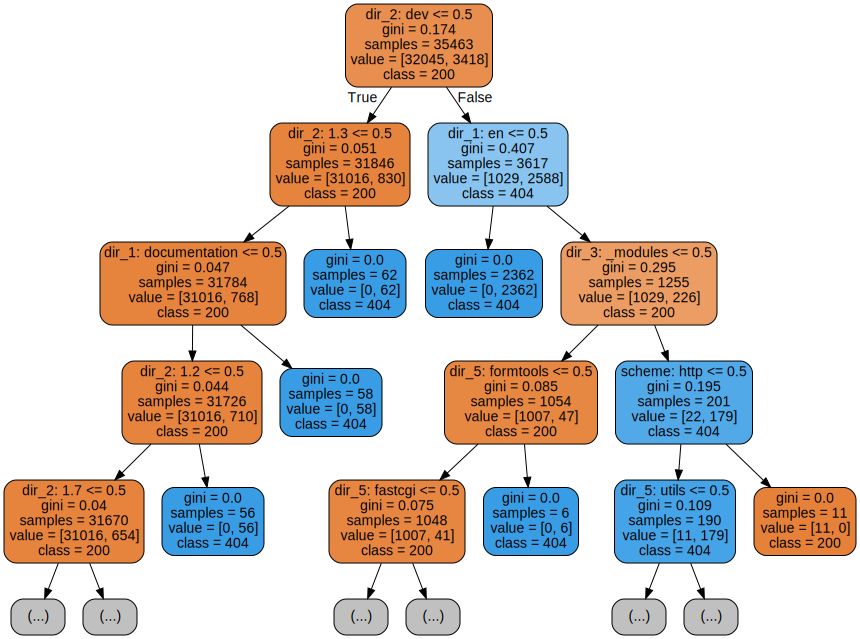

In [69]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True,
                                class_names=[str(c) for c in clf.classes_],
                                max_depth=4, 
                                feature_names=X.columns)
graph = graphviz.Source(dot_data)
graph

According to he above tree, URLs where `dir_2` is equal to "dev" and where `dir_1` is **not** equal to "en", contain 2,362 404s. Let's check and compare that with the total:

In [70]:
crawl_df[crawl_df['url'].str.contains('/dev/') & ~crawl_df['url'].str.contains('/en/')]['status'].value_counts()

404    2362
Name: status, dtype: int64

In [71]:
crawl_df['status'].value_counts()

200    32045
404     3418
Name: status, dtype: int64

$2,362 ÷ 3,418 = 0.69$

It looks like we captured almost 70% of all the 404s just by following these two rules. The second one is still very small, adding about 200 samples to the final. If you also look at the number of samples in the blue boxes, you'll easily see how small the numbers are, meaning there isn't a clear pattern after the first few levels in the tree, which is normal.  
It's not clear why the `/dev/` URLs generate so many URLs, and it would be interesting to see. It could be that the documentation automatically links to certain pages in the latest version, and those pages haven't been generated yet (because it's the "dev" version)?  
Maybe! 